# **Notebook Setup: Import Libraries**

In [ ]:
#Libraries for Data Loading & Pre-processing
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Libraries for developing, training, and running GRU Neural Network
import tensorflow as tf

#Libraries for Metric Evaluation
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

#Fallback api to fetch stock data
import yfinance

# **Setup: Parameter Adjustment**

In [ ]:
#Variables & Parameters to adjust below

#Data Loading
stock = "TSLA"
split = 0.8 #Test data is automatically calculated based on this

#Data Pre-processing
rw = 1 #Rollng Window or Input Window size

#Keras Layers Paramaters
#GRU Layer
units = 5
activation = 'tanh'
#Dropout Layer
dropout = 0.2

#Compiling Parameters
loss = "mean_squared_error"
loss_scale_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
metrics = ["mean_squared_error", "mean_absolute_error"]

#Model Fitting Parameters
epochs = 3
batch_size = 1

# **Step 1: Data Loading**

In [ ]:
try:
  # Attempt to load data from local directory first
  df = pd.read_csv(f'../data/{stock}.csv')
  print(f"Successfully loaded data for {stock} from local directory '../data/'.")

except Exception as e:
  print(f"Failed to load data from local directory: {e}")
  print(f"Attempting to fetch data for {stock} using yfinance...")

  try:
    # Tries to load data from yfinance api since google drive methood failed.
    stock_data = yfinance.Ticker(stock)
    df = stock_data.history(period="max")

    # yfinance uses 'Date' as index, reset to a column for consistency
    df = df.reset_index()
    df.rename(columns={'Date': 'date', 'Close': 'close', 'Volume': 'volume', 'Open': 'open', 'High': 'high', 'Low': 'low'}, inplace=True)

    # Prophet requires 'ds' and 'y' columns
    df2 = pd.DataFrame()
    df2['ds'] = df['date'].dt.date
    df2['y'] = df['close']

    df = df2.copy()

    if not df.empty:
      print(f"Successfully fetched data for {stock} using yfinance.")
    else:
      print("ERROR: No data could be loaded for analysis. Please check the ticker symbol matches yfinance")

  except Exception as e:
    print(f"Failed to fetch data for {stock} using yfinance: {e}")
    print("Both methods failed. Please ensure the data file is in '/content/drive/MyDrive/psxdata/stocks/'")
    print(f"or that '{stock}' is a valid ticker symbol on yfinance.")
    df = None # Ensure df is None if both methods fail

In [ ]:
# Displays the last 5 rows of the loaded dataset, check to make sure it's correct
if df is not None:
  print(df.tail())
else:
  print("Data could not be loaded using either method.")

              ds           y
3769  2025-06-24  340.470001
3770  2025-06-25  327.549988
3771  2025-06-26  325.779999
3772  2025-06-27  323.630005
3773  2025-06-30  317.660004


# **Step 2: Data Pre-Processing**

In [ ]:
# Extract the date and closing price columns
dates = df['ds']
closing_prices = df['y']

# Calculate the number of data points for training and testing
number_of_data_points = len(df)
train_data_size = math.ceil(number_of_data_points * split)
print("Training Data Split Size:", train_data_size)

# Split the data into training and testing sets
train_data = pd.DataFrame(data={'Date': dates[:train_data_size], 'Close': closing_prices[:train_data_size]})
test_data = pd.DataFrame(data={'Date': dates[train_data_size:], 'Close': closing_prices[train_data_size:]})

# Print the first few rows of the training and testing data
print('Training data:')
print(train_data.head())
print("Training Data Shape", train_data.shape)

print('Testing data:')
print(test_data.head())
print("Testing Data Shape", test_data.shape)

Training Data Split Size: 3020
Training data:
         Date     Close
0  2010-06-29  1.592667
1  2010-06-30  1.588667
2  2010-07-01  1.464000
3  2010-07-02  1.280000
4  2010-07-06  1.074000
Training Data Shape (3020, 2)
Testing data:
            Date       Close
3020  2022-06-28  232.663330
3021  2022-06-29  228.490005
3022  2022-06-30  224.473328
3023  2022-07-01  227.263336
3024  2022-07-05  233.066666
Testing Data Shape (754, 2)


In [ ]:
# Selecting Open Price values for Training Data
dataset_train = train_data.Close.values
print("OG Dataset_train 1 Dimensional:", dataset_train.shape)

# Reshaping 1D to 2D array for Training Data
dataset_train = np.reshape(dataset_train, (-1,1))
print("New Dataset_train 2 Dimensional:", dataset_train.shape)


# Selecting Open Price values for Testing Data
dataset_test = test_data.Close.values
print("OG Dataset_test 1 Dimensional:", dataset_test.shape)

# Reshaping 1D to 2D array for Testing Data
dataset_test = np.reshape(dataset_test, (-1,1))
print("New Dataset_test 2 Dimensional:", dataset_test.shape)

OG Dataset_train 1 Dimensional: (3020,)
New Dataset_train 2 Dimensional: (3020, 1)
OG Dataset_test 1 Dimensional: (754,)
New Dataset_test 2 Dimensional: (754, 1)


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
# scaling both datasets, Normalizing values between 0 and 1
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

print("Training Dataset Normalized")
print(scaled_train[:5])
print("Normalized Training Dataset Shape:", scaled_train.shape)

print("Testing Dataset Normalized")
print(scaled_test[:5])
print("Normalized Testing Dataset Shape:", scaled_test.shape)

Training Dataset Normalized
[[1.31893362e-03]
 [1.30915180e-03]
 [1.00428027e-03]
 [5.54310805e-04]
 [5.05407544e-05]]
Normalized Training Dataset Shape: (3020, 1)
Testing Dataset Normalized
[[0.33506385]
 [0.32383799]
 [0.3130335 ]
 [0.32053836]
 [0.33614878]]
Normalized Testing Dataset Shape: (754, 1)


In [ ]:
#For training set
X_train = []
y_train = []

for i in range(rw, len(scaled_train)):
    X_train.append(scaled_train[i-rw:i, 0])
    y_train.append(scaled_train[i, 0])
    if i <= rw:
        print("Training set,", rw, "Input Window Size to predict 1 Output Value")
        print(X_train)
        print(y_train)
        print()

#For testing set
X_test = []
y_test = []
for i in range(rw, len(scaled_test)):
    X_test.append(scaled_test[i-rw:i, 0])
    y_test.append(scaled_test[i, 0])
    if i <= rw:
        print("Testing set,", rw, "Input Window Size to predict 1 Output Value")
        print(X_test)
        print(y_test)
        print()

Training set, 1 Input Window Size to predict 1 Output Value
[array([0.00131893])]
[np.float64(0.0013091517972054325)]

Testing set, 1 Input Window Size to predict 1 Output Value
[array([0.33506385])]
[np.float64(0.323837990285738)]



In [ ]:
# The data is converted to Numpy array

#For training set
X_train = np.array(X_train)
y_train = np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train:" , X_train.shape )
print("y_train:" , y_train.shape)


#For testing set
X_test = np.array(X_test)
y_test = np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (3019, 1, 1)
y_train: (3019, 1)
X_test: (753, 1, 1)
y_test: (753, 1)


# **Step 4: Building the Model**

In [ ]:
#Initialising the GRU model
model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(units, input_shape=(X_train.shape[1], 1), activation=activation),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(1, activation='relu')
])

# Compiling GRU
model.compile(loss = loss, optimizer = loss_scale_optimizer)

# Fitting the data
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
3019/3019 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0097
Epoch 2/3
3019/3019 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0044
Epoch 3/3
3019/3019 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0031


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254 (1020.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 128 (516.00 B)

# **Step 5: Make Forecast**

In [ ]:
# predictions with X_test data
y_GRU = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# scaling back from 0-1 to original, Un-Normalize the values
y_GRU_O = scaler.inverse_transform(y_GRU)
y_test_O = scaler.inverse_transform(y_test)

In [ ]:
#Verifying data shapes
print("Test Data Shape:", test_data.shape)
print("Predicted Data Shape:", y_GRU_O.shape)
print("y_test Data Shape:", y_test_O.shape)

Test Data Shape: (754, 2)
Predicted Data Shape: (753, 1)
y_test Data Shape: (753, 1)


# **Step 6: Visualizing Graphs**

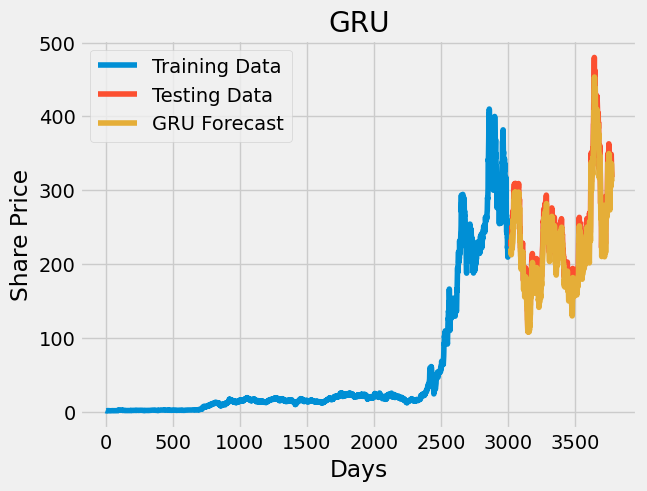

In [ ]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots() #figsize=(18, 12)

# Plot for GRU predictions
ax.plot(train_data.index, train_data.Close, label="Training Data")
ax.plot(test_data.index, test_data.Close, label="Testing Data")
ax.plot(test_data.index[rw:], y_GRU_O, label="GRU Forecast")
ax.legend()
ax.title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Share Price")

plt.show()

# **Step 7: Evaluate Model Accuracy**

In [ ]:
# calculate mean squared error
mse = mean_squared_error(y_test_O, y_GRU_O)
print('Mean Squared Error (MSE):', mse)

# calculate mean absolute error
mae = mean_absolute_error(y_test_O, y_GRU_O)
print('Mean Absolute Error (MAE):', mae)

# calculate root mean squared error
rmse = math.sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

# calculate mean absolute percentage error
mae = mean_absolute_percentage_error(y_test_O, y_GRU_O)
print('Mean Absolute Percentage Error (MAPE):', mae*100)

Mean Absolute Error (MAE): 13.249980870787683
Mean Absolute Percentage Error (MAPE): 5.712834298266725
Mean Squared Error (MSE): 246.30311149745842
Mean Squared Log Error (MSLE): 0.00483897960293683
Root Mean Squared Error (RMSE): 0.06956277454886939
